### The AQIC and Fire Alarm projects are supported via NASA's Earth Science Technology Office (ESTO) from the Advanced Information Systems Technology (AIST) Program

# Fire Alarm: Science Data Platform for Wildfire and Air Quality API Demonstration

## Libraries, Functions and Inventories

The following libraries are needed to support accessing FireAlarm API. The functions called in this notebook are in the `firealarm_modules` folder.

### Libraries

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from IPython.display import Image
from owslib.wms import WebMapService
from urllib.request import urlopen
from PIL import Image as I
from PIL import ImageDraw, ImageFont

import firealarm_modules.plotting as plotting
import firealarm_modules.firealarm_processing as firealarm_processing

### Fire Alarm: Science Data Platform for Wildfire and Air Quality  DATA Inventory

The base url, https://ideas-digitaltwin.jpl.nasa.gov/nexus, is the entry to access FireAlarm API. In the following code snipet, it is used in conjunction with list endpoint to get a list of datasets.

In [2]:
BASE_URL = 'https://ideas-digitaltwin.jpl.nasa.gov'
NEXUS_URL = f'{BASE_URL}/nexus'
INSITU_URL = f'{BASE_URL}/insitu/1.0'

### Satellite and Model data inventory

In [3]:
aq_datasets = firealarm_processing.get_datasets()

In [4]:
pd.concat([aq_datasets[['GlobalAttrTitle', 'GlobalAttrSource']].head(), aq_datasets[['GlobalAttrTitle', 'GlobalAttrSource']].tail()])

,GlobalAttrTitle,GlobalAttrSource
0,MERRA-2 Global CDH,GES DISC
1,MERRA-2 Global PBLH,GES DISC
2,MERRA-2 Global TLML,GES DISC
3,MODIS Terra AOD 550 Dark Target Deep Blue Comb...,Giovanni
4,MODIS Terra Aerosol Optical Depth Land Ocean Mean,Giovanni
24,Sentinel-5P TROPOMI Methane CH4 California,GES DISC
25,Sentinel-5P TROPOMI Carbon Monoxide CO California,GES DISC
26,Sentinel-5P TROPOMI Tropospheric NO2 California,GES DISC
27,Sentinel-5P TROPOMI Total Ozone California,GES DISC
28,Sentinel-5P TROPOMI Sulphur Dioxide SO2 Califo...,GES DISC


### In-situ data inventory

In [5]:
insitu_collections = firealarm_processing.get_insitu_collections()
insitu_collections

,provider,project
0,AirNow,air_quality
1,AirNow,AQACF
2,GRIMM-Aethalometer,AQACF
3,PurpleAir,AQACF
4,QuantAQ,AQIC-Raw
5,QuantAQ,AQIC
6,QuantAQ,AQIC-Hourly
7,PurpleAir-GMU-Cal,air_quality
8,PurpleAir-GMU-Intermediate,air_quality
9,PurpleAir-GMU-Raw-Hourly,air_quality


In [6]:
airnow_sites = firealarm_processing.get_insitu_sites('air_quality', 'AirNow').drop_duplicates(['platform_short_name']).reset_index()
airnow_sites

,index,platform,platform_short_name,lat,lon,min_datetime,max_datetime
0,0,000010102,St. John's,47.652800,-52.816700,2018-01-01T00:00:00Z,2022-02-28T00:00:00Z
1,1,000010401,Mount Pearl,47.505000,-52.794700,2018-01-01T00:00:00Z,2022-02-28T00:00:00Z
2,2,000010501,Grand Falls Windsor,49.019400,-55.802800,2018-01-01T00:00:00Z,2021-03-31T00:00:00Z
3,3,000010601,Goose Bay,53.304700,-60.364400,2018-01-02T00:00:00Z,2024-03-31T00:00:00Z
4,4,000010602,MacPherson Avenue - Corner Brook,48.952240,-57.922070,2020-01-01T00:00:00Z,2022-02-28T00:00:00Z
...,...,...,...,...,...,...,...
3471,7059,TT1010003,Inchelium,48.296960,-118.202420,2018-01-09T00:00:00Z,2019-05-31T00:00:00Z
3472,7060,TT5420500,Santa Rosa Rancheria,36.233333,-119.765083,2018-01-01T00:00:00Z,2023-08-24T00:00:00Z
3473,7062,TT9209004,Miami,36.922222,-94.838890,2018-01-01T00:00:00Z,2024-03-31T00:00:00Z
3474,7064,UB1010001,Ulaanbaatar,47.928385,106.929470,2018-01-01T00:00:00Z,2024-03-31T00:00:00Z


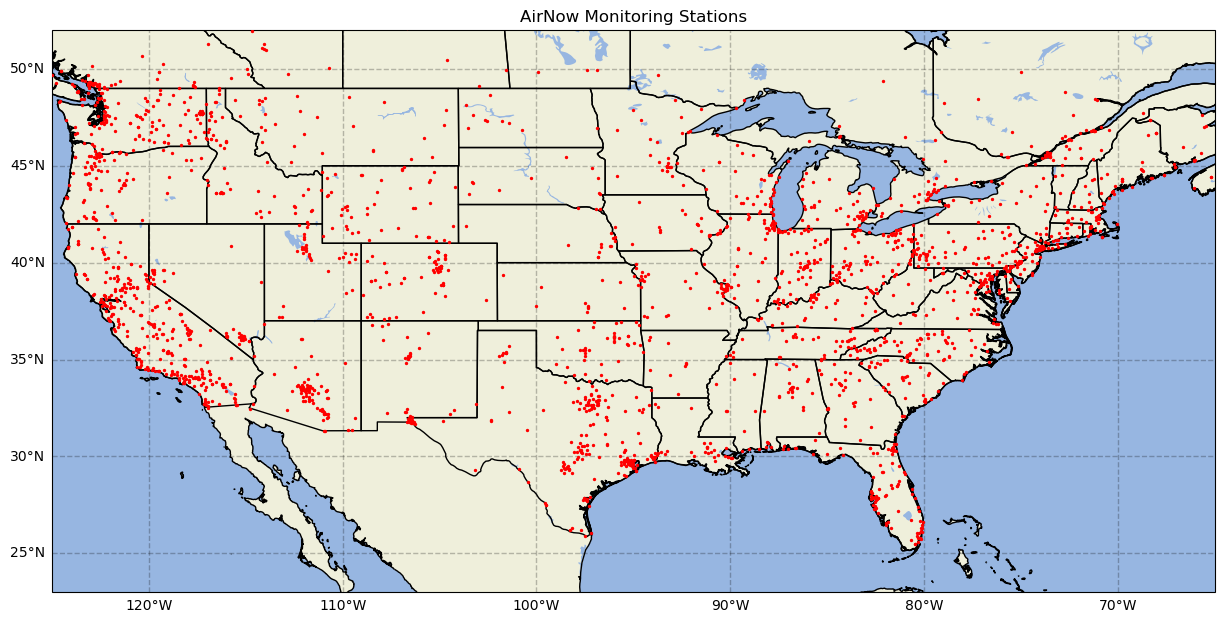

In [7]:
formatted_sites = [(s['lat'], s['lon'], s['platform_short_name']) for i,s in airnow_sites.iterrows()]
plotting.map_points(formatted_sites, region='usa', title='AirNow Monitoring Stations', legend=False, roads=False)

# 2023 Canada Wildfires Impacting New York Air Quality

### Area of Interest

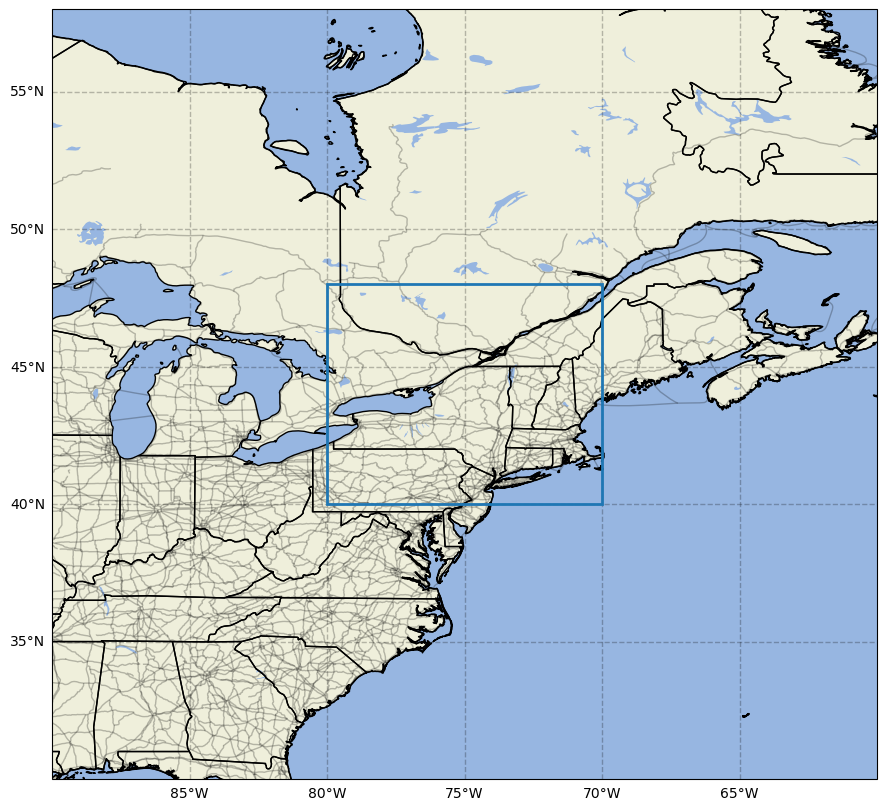

In [8]:
ca_wildfires_bb = {'min_lon': -80, 'max_lon': -70, 'min_lat': 40, 'max_lat': 48}
ca_start = datetime(2023,5,15)
ca_end = datetime(2023,6,15)

plotting.map_box(ca_wildfires_bb, padding=10)

In [9]:
tropomi_co_can_ts = firealarm_processing.spatial_timeseries('TROPOMI_CO_global', ca_wildfires_bb, ca_start, ca_end)

https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=TROPOMI_CO_global&minLon=-80&minLat=40&maxLon=-70&maxLat=48&startTime=2023-05-15T00%3A00%3A00Z&endTime=2023-06-15T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 11.657201582998823 seconds


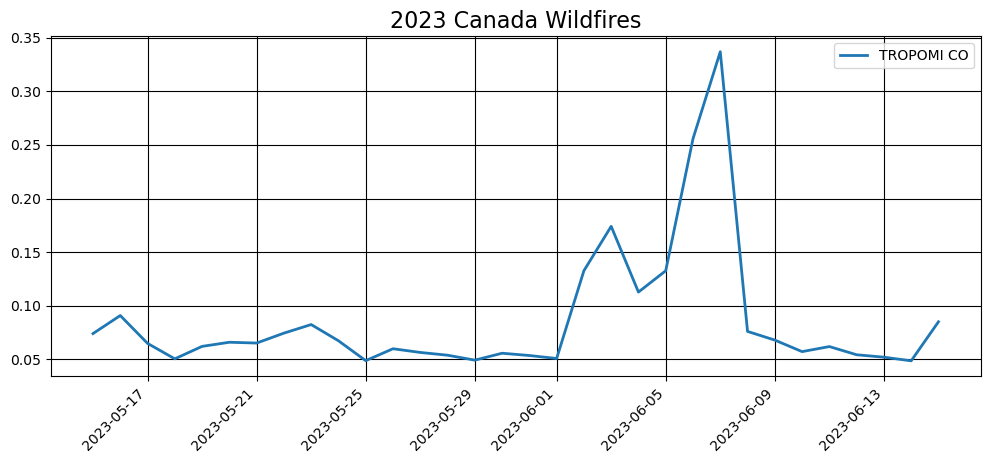

In [10]:
plotting.timeseries_plot([(tropomi_co_can_ts['maximum'], 'TROPOMI CO')], '', '', '2023 Canada Wildfires', norm=False)

### TROPOMI CO 2023-06-07

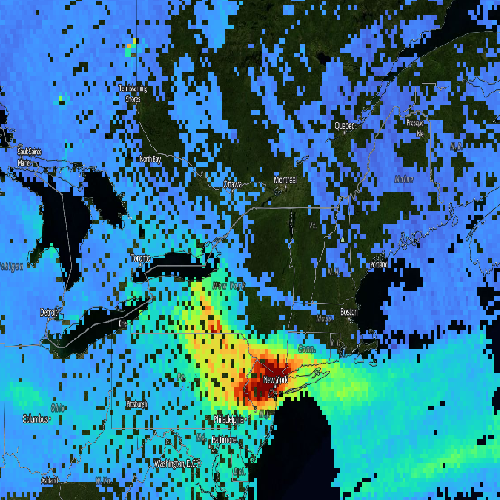

In [11]:
# Connect to FireAlarm OnEarth WMS Service
wms = WebMapService('https://ideas-digitaltwin.jpl.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

layers = ['BlueMarble_NextGeneration',
          'TROPOMI_global_carbonmonoxide_total_column',
          'Reference_Features',
          'Reference_Labels']
font = ImageFont.truetype('Roboto-Bold.ttf', size=18)
color = 'rgb(255,255,255)'
frames = []

datatime = datetime(2023,6,7).strftime("%Y-%m-%d")
img = wms.getmap(layers=layers,  # Layers
                    srs='epsg:4326',  # Map projection
                    bbox=(-85, 38, -65, 50), # Bounds
                    size=(500, 500),  # Image size
                    time=datatime,  # Time of data
                    format='image/png',  # Image format
                    transparent=True)  # Nodata transparency
Image(img.read())

In [12]:
viirs_subset_date = datetime(2023,6,7)
viirs_ca_subset = firealarm_processing.data_subsetting('laads-1degx1deg-daily-global_Aerosol_Optical_Thickness_550_Land_Ocean_Mean', ca_wildfires_bb, viirs_subset_date, viirs_subset_date, 'Aerosol_Optical_Thickness_550_Land_Ocean_Mean')

https://ideas-digitaltwin.jpl.nasa.gov/nexus/datainbounds?ds=laads-1degx1deg-daily-global_Aerosol_Optical_Thickness_550_Land_Ocean_Mean&b=-80%2C40%2C-70%2C48&startTime=2023-06-07T00%3A00%3A00Z&endTime=2023-06-07T00%3A00%3A00Z

Waiting for response from FireAlarm...took 1.014873374999297 seconds


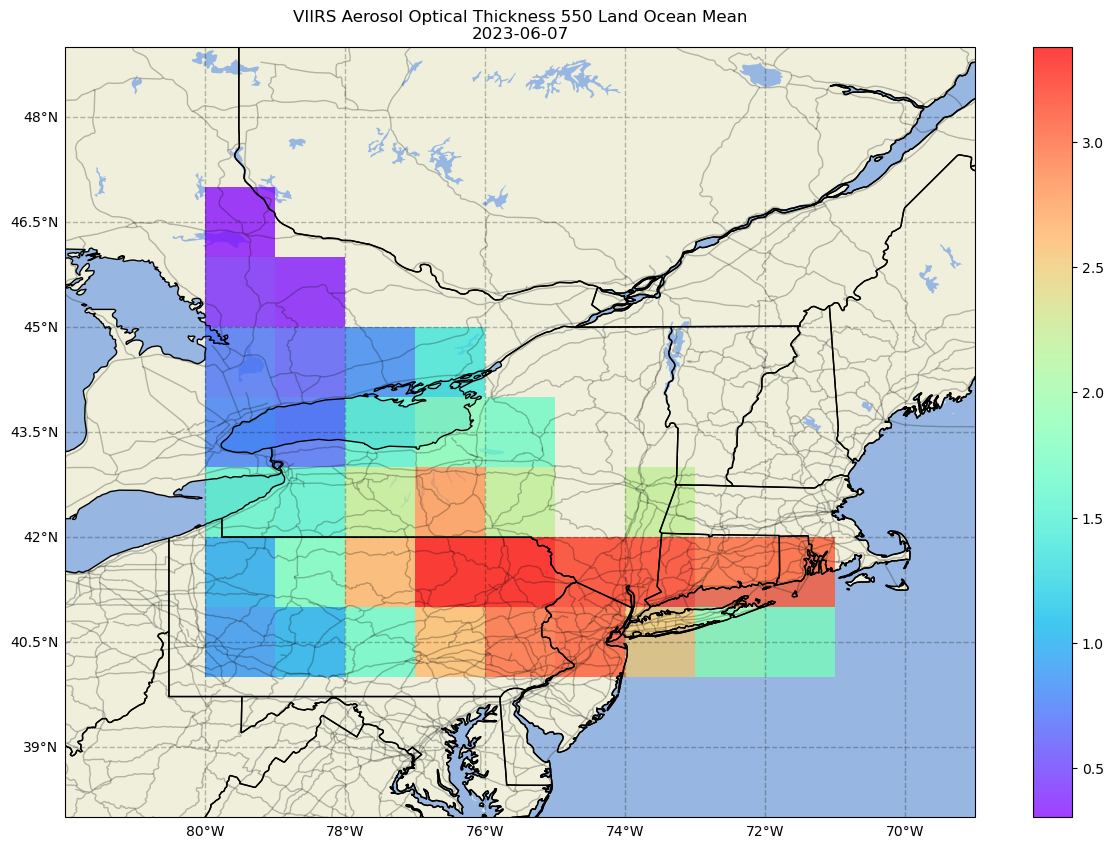

In [13]:
plotting.map_data(viirs_ca_subset[0], f'VIIRS Aerosol Optical Thickness 550 Land Ocean Mean\n{viirs_subset_date.strftime("%Y-%m-%d")}')

In [14]:
geos_pm25_can_ts =  firealarm_processing.spatial_timeseries('GEOS-CF_aqc_tavg_1hr_PM25', ca_wildfires_bb, ca_start, ca_end)

https://ideas-digitaltwin.jpl.nasa.gov/nexus/timeSeriesSpark?ds=GEOS-CF_aqc_tavg_1hr_PM25&minLon=-80&minLat=40&maxLon=-70&maxLat=48&startTime=2023-05-15T00%3A00%3A00Z&endTime=2023-06-15T00%3A00%3A00Z&lowPassFilter=False

Waiting for response from FireAlarm...took 4.27437554199787 seconds


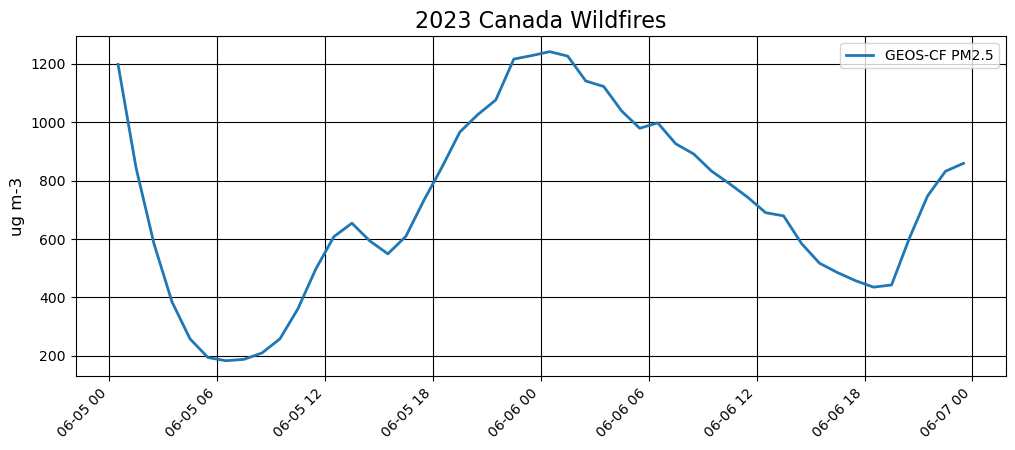

In [15]:
plotting.timeseries_plot([(geos_pm25_can_ts['maximum'], 'GEOS-CF PM2.5')], '', 'ug m-3', '2023 Canada Wildfires', norm=False)

## In-situ Sites

In [16]:
ny_sites = airnow_sites[(airnow_sites['lat']>40) & (airnow_sites['lat']< 44) & (airnow_sites['lon']>-80) & (airnow_sites['lon']< -70)]
formatted_ny_sites = [(s['lat'], s['lon'], s['platform_short_name']) for i,s in ny_sites.iterrows()]

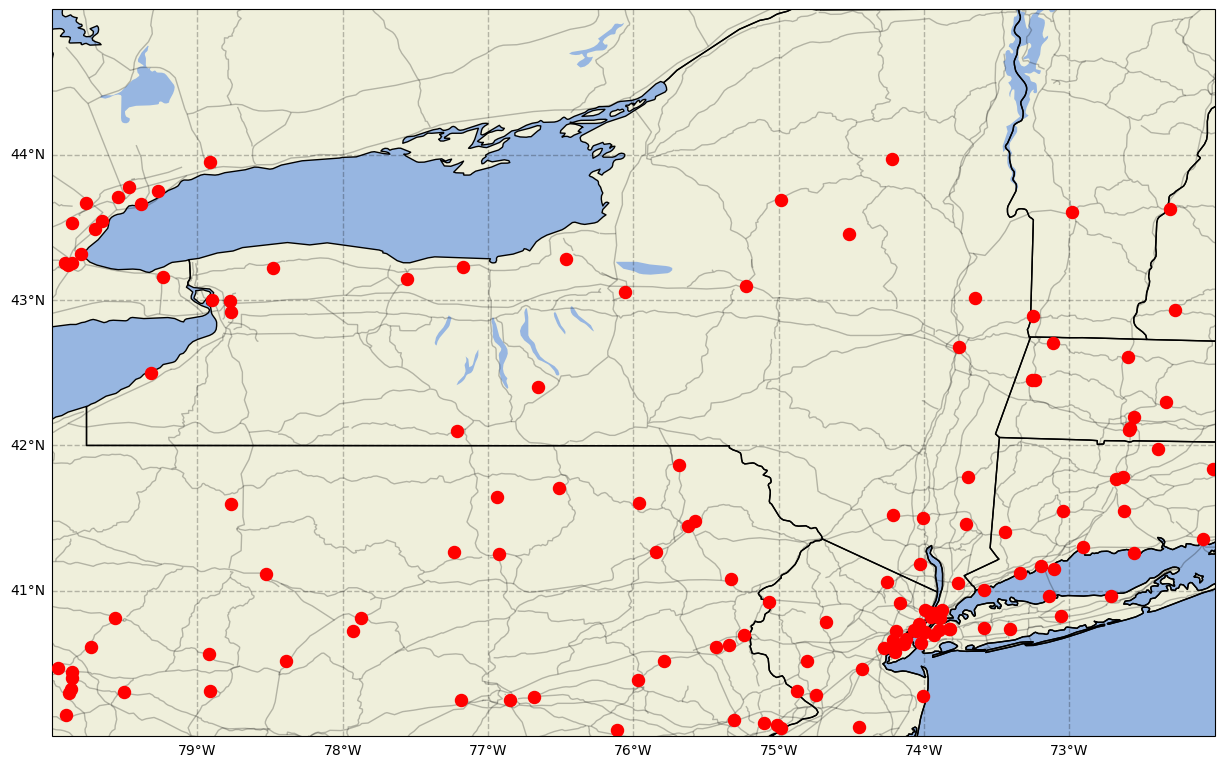

In [17]:
plotting.map_points(formatted_ny_sites, region='newyork', legend=False)

In [18]:
ca_fire_insitu = firealarm_processing.insitu('AirNow', 'AQACF', '-80,40,-72,43.5', datetime(2023,5,15), datetime(2023,6,15))

https://ideas-digitaltwin.jpl.nasa.gov/insitu/1.0/query_data_doms_custom_pagination?startIndex=0&itemsPerPage=10000&provider=AirNow&project=AQACF&startTime=2023-05-15T00:00:00Z&endTime=2023-06-15T00:00:00Z&bbox=-80,40,-72,43.5


In [19]:
prepped_results = [(ca_fire_insitu[ca_fire_insitu['short_name'] == sn], 'pm2_5', f'AirNow {sn}') for sn in ca_fire_insitu.short_name.unique()]

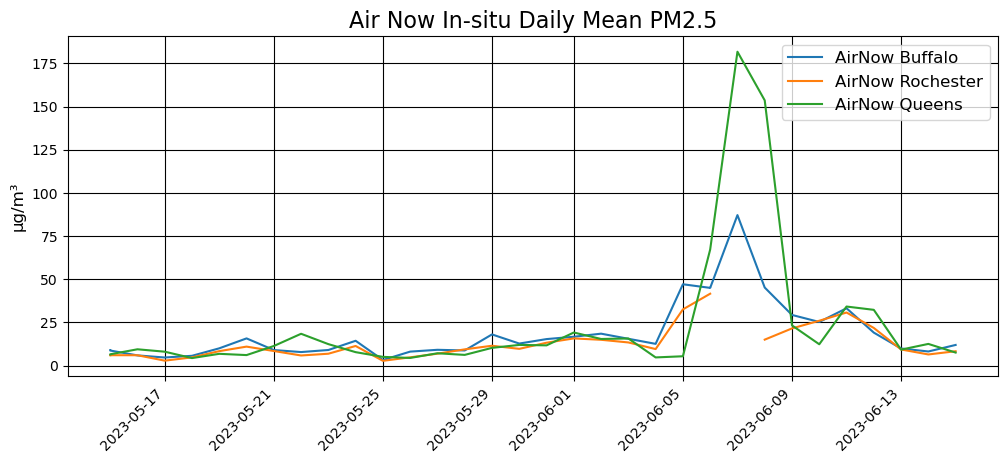

In [20]:
plotting.plot_insitu(prepped_results, 'Air Now In-situ Daily Mean PM2.5', 'µg/m³')